# Multi-Objective Portfolio Optimization

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

We saw in the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/03_Portfolio_Optimization_Using_Signals.ipynb) how to optimize a portfolio model that uses signals to allocate its stock-weights. The performance measure that was being optimized was the mean-log return (aka. Kelly Criterion) with a severe penalty if there were too many losses. This was a simple way of optimizing multiple objectives with an optimizer that could only handle a single objective.

In this paper we will instead use a multi-objective optimizer that can deal with the objectives individually. This allows us to select which portfolio model to use so as to adjust the compromise between returns and the probability of losses.

Most of the source-code is the same as in the previous paper but it is probably easier to read, understand and modify the code if it is contained in a single Notebook and Python-file. However, it is still recommended that you at least watch the video for the previous paper, because some things are explained in more detail there.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

/home/magnus/anaconda3/envs/swarmops/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_stock_data, load_index_data
from portfolio_multi import EqualWeights, FixedWeights, AdaptiveWeights
from returns import daily_returns

## Variance is NOT Risk!

In a dictionary the word "risk" means the "chance of injury or loss". Markowitz' mean-variance portfolio theory is based on the notion that variance of a return distribution measures its investment "risk". But that is incorrect, because the variance measures the spread of the return distribution rather than its probability of loss. I have previously made YouTube videos explaining this problem [here](https://www.youtube.com/watch?v=wr8NzThfpAE) and [here](https://www.youtube.com/watch?v=0temN7hAf2c).

Some people believe that as long as the returns are normal-distributed then their variance does actually measure investment risk. But that is also wrong, as we will demonstrate now.

In [4]:
from scipy.stats import norm
from ipywidgets import interact, FloatSlider

In [5]:
def plot_normal(mean, std):
    """
    Plot the normal-distribution with the given mean and
    standard-deviation. Show the losses in red and show
    the gains in green. Also print the probability of loss.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Arrays with negative and positive x-values.
    x1 = np.linspace(-1, 0, 100)
    x2 = np.linspace(0, 1, 100)

    # Arrays with y-values for the normal distribution.
    y1 = norm.pdf(x1, loc=mean, scale=std)
    y2 = norm.pdf(x2, loc=mean, scale=std)
    
    # Fill loss-area with red.
    ax.fill_between(x1, 0.0, y1, color="red", edgecolor="red")

    # Fill gain-area with green.
    ax.fill_between(x2, 0.0, y2, color="green", edgecolor="green")

    # Vertical dashed line for the mean.
    ax.axvline(x=mean, ymin=0, ymax=1, color="black", ls="dashed")

    # Vertial line for x=0
    ax.axvline(x=0.0, ymin=0, ymax=1, color="black")
    
    # Print the probability of loss.
    prob = norm(loc=mean, scale=std).cdf(0.0)
    msg = "Probability of loss: {0:.3f}".format(prob)
    ax.text(-0.5, 0.02, msg)

    # Ensure the plot is shown correctly.
    plt.show()

Using the above function, we can make an interactive plot where you can move the sliders to change the mean and standard deviation. You should try a few experiments:

1. Select a positive mean and vary the standard deviation. This shows that the probability of loss varies in direct proportion to the standard deviation.

2. Change the mean but keep it positive while keeping the standard deviation fixed. This shows that the probability of loss depends on both the mean and standard deviation.

3. Select a negative mean and vary the standard deviation. This shows that the probability of loss varies **inversely** with the standard deviation, so that a low standard deviation actually results in a high probability of loss, and vice versa.

From this demonstration it is obvious that the standard deviation (or equivalently the variance) is completely useless as a risk-measure!

In [6]:
mean_slider = FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1)
std_slider = FloatSlider(value=0.1, min=0.05, max=1.0, step=0.05)
_ = interact(plot_normal, mean=mean_slider, std=std_slider)

interactive(children=(FloatSlider(value=0.0, description='mean', max=1.0, min=-1.0), FloatSlider(value=0.1, de…

## Flowchart

We have now established the fact that variance does not measure investment risk in any meaningful way. We will instead optimize a portfolio model so that it can trade off between conflicting goals such as the mean return and the probability of loss.

The overall idea is very similar to the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/03_Portfolio_Optimization_Using_Signals.ipynb). We create a portfolio model which is basically just a mathematical function that maps the predictive signals to stock-weights. The portfolio model has a number of parameters that are found using a heuristic optimizer so as to result in good investment performance.

The difference here is that the optimizer uses two separate fitness measures: The mean return for all 12-month periods, and the probability of loss for all 3-month periods. We feed these two separate fitness measures into the multi-objective optimizer known as NSGA-2 (short for Non-Dominated Sorting Genetic Algorithm version 2), which then proposes new model parameters whose fitness values can be calculated. This loop is repeated until a so-called Pareto-front of solutions is found, which optimally compromises between the two conflicting goals.

The flowchart shows roughly how this works.

![Flowchart](images/04_flowchart_multi_objective.png)

## Load Data

We now define and load all the financial data we will be using.

In [7]:
# Ticker-names for the stock indices.
ticker_SP500 = "S&P 500"
ticker_SP400 = "S&P 400"
ticker_SP600 = "S&P 600"
tickers_indices = [ticker_SP500, ticker_SP400, ticker_SP600]

Data is also included for the stocks GPC and WMT but doing the analysis in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) on those two stocks shows that their P/Sales ratios are not a good predictor for their returns, so those two stocks are omitted here.

In [8]:
# Ticker-names for the stocks.
tickers_stocks = ['CLX', 'CPB', 'DE', 'DIS', 'GIS',
                  'HSY', 'JNJ', 'K', 'PG']

In [9]:
# List of all tickers for the indices and stocks.
tickers = tickers_indices + tickers_stocks

In [10]:
# Load the financial data for the stock indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400,
                           sales=False, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600,
                           sales=False, book_value=False)

# DataFrames for all stock indices.
dfs_indices = [df_SP500, df_SP400, df_SP600]

In [11]:
# Load financial data for all stocks to a list of DataFrames.
dfs_stocks = [load_stock_data(ticker=ticker)
              for ticker in tickers_stocks]

In [12]:
# List of all DataFrames for the indices and stocks.
dfs = dfs_indices + dfs_stocks

In [13]:
# Total number of stocks and indices.
num_stocks = len(dfs)
num_stocks

12

## Predictive Signals

We saw in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) that the P/Sales ratio was a strong predictor for the long-term returns of the S&P 500 and some individual stocks, so we will be using the P/Sales ratio as the predictive signal for those stocks.

For the S&P 400 and S&P 600 indices we do not have the P/Sales data but we do have the Dividend Yield, which is also a good predictor for the long-term returns of those indices. You should confirm this by doing the analysis in the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) for those two indices.

It is extremely important that you analyse the relationship between a given signal and the stock returns before you use that signal, because the optimizer will try and uncover a relationship whether there really is one or not. It may work very well on the training-set, but it may not generalize to the future.

You should therefore always do analysis like the [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) before you use a predictive signal!

Similarly, you should be careful that your mathematical model only maps signals to stock-weights where the signal has a causal relationship with that particular stock. For example, a fully-connected neural network would allow all signals to be used to determine the weights for all the stocks, but the P/Sales for one company clearly has nothing to do with the future return of another company's stock - except for perhaps a historical coincidence in the training-set, which is unlikely to occur again in the future.

Note that we make a simple implementation here which only allows one signal per stock.

In [14]:
# Predictive signals for the stock indices.
signals_indices = [df_SP500[PSALES],
                   df_SP400[DIVIDEND_YIELD],
                   df_SP600[DIVIDEND_YIELD]]

In [15]:
# Predictive signals for the stocks.
signals_stocks = [df[PSALES] for df in dfs_stocks]

In [16]:
# Combine all the signals into a single list.
signals = signals_indices + signals_stocks

In [17]:
# Create a Pandas DataFrame.
df_signals = pd.concat(signals, axis=1)

In [18]:
# Remove rows with missing data.
df_signals.dropna(inplace=True)

In [19]:
# Show the top rows of the valid signals.
df_signals.head()

,P/Sales,Dividend Yield,Dividend Yield,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales,P/Sales
Date,,,,,,,,,,,,
1994-09-30,0.904257,0.020246,0.011155,1.491139,1.508969,0.659435,2.064559,1.036528,1.094454,2.405291,1.998021,1.313643
1994-10-01,0.903559,0.020276,0.011180,1.486003,1.511047,0.660563,2.083179,1.035625,1.096352,2.398748,1.999083,1.311459
1994-10-02,0.902861,0.020305,0.011205,1.480870,1.513128,0.661691,2.101774,1.034720,1.098250,2.392209,2.000145,1.309276
1994-10-03,0.902164,0.020335,0.011230,1.475739,1.515209,0.662819,2.120346,1.033812,1.100147,2.385674,2.001207,1.307094
1994-10-04,0.888129,0.020631,0.011419,1.471802,1.472666,0.642335,2.072468,1.030647,1.090902,2.326918,1.983420,1.298494


In [20]:
# Period for which we have valid signals.
start_date, end_date = df_signals.index[[0, -1]]

In [21]:
# The raw unscaled signals.
signals_raw = df_signals.values

In [22]:
# The signals could have widely different ranges,
# so we scale the signals to be between 0.0 and 1.0
signals_scaler = MinMaxScaler()
signals_scaled = signals_scaler.fit_transform(signals_raw)

## Daily Returns

We need the daily returns for all the stocks because we will rebalance the portfolio every day according to the stock-weights produced by our portfolio model.

We use interpolated data so we have the stock-prices and their daily returns for all days including weekends and holidays. This makes the programming easier for this demonstration, but a real implementation should probably only use real data points to avoid distortions.

In [23]:
# Add a day to the period because we most likely have the
# Total Return data for that day as well, and that means
# we calculate the daily return for the end_date as well.
end_date_plus1 = end_date + pd.DateOffset(days=1)

In [24]:
# Calculate daily returns using the Total Return for all stocks.
daily_rets = np.array([daily_returns(df, start_date, end_date_plus1)
                       for df in dfs])

In [25]:
# Transpose the 2-dim array.
daily_rets = daily_rets.T
daily_rets.shape

(8311, 12)

In [26]:
# Remove the last row which only contains NAN.
daily_rets = daily_rets[0:-1, :]
daily_rets.shape

(8310, 12)

## Weight Bounds

We only allow for so-called "long" investing without margin, which means that the stock-weights are bounded between 0.0 and 1.0, and their sum must be less or equal to 1.0.

In [27]:
min_weights = np.zeros(num_stocks, dtype=np.float)
max_weights = np.ones(num_stocks, dtype=np.float)

Furthermore, we limit the weights for the individual stocks to 0.2 (or 20%) of the portfolio, while allowing the stock-indices to have weights up to 1.0 (or 100%) of the portfolio. This is an attempt to regularize the portfolio model so it does not overfit to the training-set. Ideally we would have many more stocks to choose from so the stock-weights could be limited to e.g. 5% of the portfolio, but when we only have a small number of stocks, that would essentially mean that the portfolio would mostly be allocted to the indices and hence track those closely.

In [28]:
max_weights[len(dfs_indices):] = 0.2

## Split Training- and Test-Sets

We now split the data-set evenly into a training-set and a test-set.

In [29]:
# Total number of data-points.
num_data = len(daily_rets)

# Number of data-points in the training-set.
num_train = int(num_data * 0.5)

In [30]:
# Indices for the training-set.
# These are used to lookup dates, daily returns, signals, etc.
idx_train = range(0, num_train)

# Indices for the test-set.
idx_test = range(num_train, num_data)

In [31]:
# All dates for the entire period.
dates = df_SP500[start_date:end_date].index

# Dates for the training-set.
dates_train = dates[0:num_train]

# Dates for the test-set.
dates_test = dates[num_train:]

In [32]:
# Daily returns for the training-set.
daily_rets_train = daily_rets[0:num_train]

# Daily returns for the test-set.
daily_rets_test = daily_rets[num_train:]

In [33]:
# Signals for the training-set.
signals_train = signals_scaled[0:num_train]

# Signals for the test-set.
signals_test = signals_scaled[num_train:]

## Portfolio with Equal Weights

The most basic portfolio model uses equal weights for all the stocks and indices. It serves as a baseline for comparison to more advanced portfolio models.

In [34]:
# Create portfolio model for equal weights.
portfolio_equal = EqualWeights(num_stocks=num_stocks, use_cash=False)

In [35]:
# Get the weights.
weights_equal, weights_cash_equal = portfolio_equal.get_weights(signals_test)

In [36]:
weights_equal

array([[0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
        0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
        0.08333333, 0.08333333]])

In [37]:
weights_cash_equal

0.0

## Portfolio with Adaptive Weights

The portfolio model with adaptive weights uses the signals for the stocks to determine the stock-weights in the portfolio. We use a simple linear function wrapped in a sigmoid-function to softly limit the result between 0.0 and 1.0. For example, the weight for the CLX stock is:

$$
    Weight_{CLX} = Sigmoid( a_{CLX} \cdot Signal_{CLX} + b_{CLX} )
$$

During optimization we are trying to find the parameters $a_{CLX}$ and $b_{CLX}$ that maximize the investment performance according to our fitness-function. We are trying to find the parameters for all stocks in the portfolio simultaneously.

There is some additional scaling on the weights to limit them between the valid boundaries, as well as ensuring that the weights for the entire portfolio are less or equal to 1.

In [38]:
%%time
# Create portfolio model for adaptive weights and find the
# model-parameters that perform best on the training-set.
portfolio_adapt = AdaptiveWeights(signals_train=signals_train,
                                  daily_rets_train=daily_rets_train,
                                  min_weights=min_weights,
                                  max_weights=max_weights)

CPU times: user 2min 14s, sys: 0 ns, total: 2min 14s
Wall time: 2min 14s


## Pareto Front

In [39]:
def plot_pareto_front(model):
    """Plot the pareto-front for the given model."""

    # Get the fitness-values to plot. These are found by
    # multi-objective optimization so they are on the
    # pareto-front and they are already sorted.
    # Note the fitness for the mean return is negated,
    # because the optimizer did minimization.
    mean_return = - model.best_fitness[:, 0]
    prob_loss = model.best_fitness[:, 1]
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Plot the pareto-front as connected lines.
    ax.plot(mean_return, prob_loss)

    # Plot dots to show the exact data-points.
    ax.scatter(mean_return, prob_loss)

    # Set title and labels.
    ax.set_title("Pareto Front for Adaptive Portfolio Model on Training-Set")
    ax.set_xlabel("Mean Return after 12 Months")
    ax.set_ylabel("Probability of Loss after 3 Months")
    
    # Convert x-ticks to percentages.
    # We use a custom FuncFormatter because PercentFormatter
    # is inconsistent with string-formatters used elsewhere.
    formatter = FuncFormatter(lambda x, _: '{:.1%}'.format(x))
    ax.xaxis.set_major_formatter(formatter)

    # Show grid.
    ax.grid()
    
    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

This plot shows the best solutions found by the optimization. The x-axis shows the mean return after 12 months and the y-axis shows the probability of loss after 3 months. The blue line is the so-called Pareto front, which represents the model parameters that optimally compromise between the two conflicting performance measures.

Note that this is for the training-set and may not generalize to the test-set.

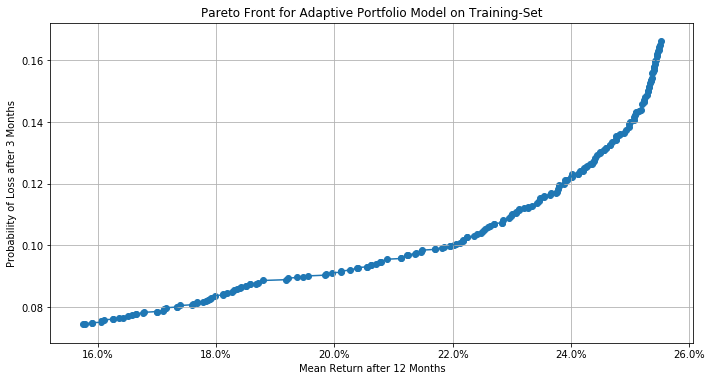

In [40]:
plot_pareto_front(model=portfolio_adapt)

The `Model`-class provides three functions for selecting parameters on the Pareto front:

- `use_best_parameters_min_prob_loss()` uses the model parameters that minimize the probability of loss.

- `use_best_parameters_max_return()` uses the model parameters that maximize the mean return.

- `use_best_parameters(max_prob_loss=0.1)` uses the model parameters that maximize the mean return while keeping the probability of loss below the given limit.

## Weight Formulas

In [41]:
def print_model_formulas():
    """
    Print the mathematical formulas for the
    portfolio-model with adaptive weights.
    """

    for ticker, a, b in zip(tickers,
                            portfolio_adapt._a,
                            portfolio_adapt._b):
        msg = "{0:8} weight = {1:6.2f} x signal + {2:6.2f}"
        print(msg.format(ticker, a, b))

We can print the linear formulas for the stock-weights that we have found in the optimization above. We ignore the sigmoid and other scalings here and show more detailed plots of the stock-weights further below.

First we show the formulas that minimized the probability of loss on the training-set.

In [42]:
portfolio_adapt.use_best_parameters_min_prob_loss()
print_model_formulas()

S&P 500  weight =  -7.86 x signal +   0.95
S&P 400  weight =   5.29 x signal +  -7.48
S&P 600  weight =   9.58 x signal +  -9.31
CLX      weight =  -9.98 x signal +   3.15
CPB      weight =  -4.88 x signal +  -7.79
DE       weight =  -9.92 x signal +   0.45
DIS      weight =  -9.75 x signal +  -8.21
GIS      weight =  -9.56 x signal +   2.20
HSY      weight =  -9.98 x signal +   1.98
JNJ      weight =  -9.95 x signal +   4.08
K        weight =  -9.96 x signal +   2.42
PG       weight =  -9.93 x signal +   4.78


Next we show the formulas that maximized the mean return on the training-set.

It is hard to see the difference between these model parameters, so it is better to plot the weights as done below.

In [43]:
portfolio_adapt.use_best_parameters_max_return()
print_model_formulas()

S&P 500  weight =  -5.87 x signal +  -9.14
S&P 400  weight =  -2.23 x signal +  -7.86
S&P 600  weight =  -0.58 x signal +  -8.33
CLX      weight = -10.00 x signal +   6.07
CPB      weight =  -9.87 x signal +  -9.48
DE       weight =  -9.99 x signal +   3.24
DIS      weight =  -9.79 x signal +   2.46
GIS      weight =  -9.84 x signal +   6.09
HSY      weight =  -9.97 x signal +   4.40
JNJ      weight =  -9.92 x signal +   6.86
K        weight =  -9.98 x signal +   3.21
PG       weight =  -9.97 x signal +   6.82


## Plot Adaptive Weights

In [44]:
def plot_weights_signals(idx):
    """
    Plot stock-weights (black fills) and signals (red lines)
    for the adaptive portfolio model, for the given period.

    :param idx: List of integer indices into dates, signals, etc.
    :return: None.
    """

    # Get the data for the period given by the indices.
    dates_idx = dates[idx]
    signals_idx = signals_scaled[idx, :]
    
    # Setup plotting.
    # A plot for each stock and a plot for the cash-weight.
    fig, axes = plt.subplots(num_stocks+1, 1, sharex=True,
                             figsize=(10, 20))

    # Get the weights for the stock and cash for this period.
    weights, weights_cash = portfolio_adapt.get_weights(signals_idx)

    # Make a plot for each stock-weight and signal.
    for i, ax in enumerate(axes[:-1]):
        # The range of the y-axis is set to the max
        # allowed weight for this stock.
        ylim = max_weights[i]
        ax.set_ylim([0, ylim])

        # Plot the stock-weights as a solid black fill.
        ax.fill_between(dates_idx, 0.0, weights[:, i],
                        color="black", edgecolor="black")

        # Plot the signal as a red line.
        # Note that signals_scaled is between 0.0 and 1.0
        # so we scale it by the ylim to use the full range
        # of the y-axis.
        signal = signals_scaled[idx, i] * ylim
        ax.plot(dates_idx, signal, color="red")

        # Plot a grid.
        ax.grid()

        # Print ticker-name in the middle of each sub-plot.
        ax.text(0.5, 0.9, tickers[i], color="green", weight="bold",
                ha="center", va="center", transform=ax.transAxes)

    # Plot the cash weights. This is similar to a stock-plot.
    ax = axes[-1]
    ax.set_ylim([0, 1])
    ax.fill_between(dates_idx, 0.0, weights_cash,
                    color="black", edgecolor="black")
    ax.text(0.5, 0.9, "Cash", color="green", weight="bold",
            ha="center", va="center", transform=ax.transAxes)
    ax.grid()

    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Stock-Weights: Min Probability of Loss

We will now plot the stock-weights for the adaptive portfolio model using different choices of model parameters.

There is a sub-plot for each stock or index. The black fill is the stock-weight with its scale given on the y-axis. The red line is the predictive signal used for that particular stock, and its scale is always between 0 and 1 because we show the normalized signals.

All stocks and indices use the P/Sales ratio as the signal, except for the S&P 400 and S&P 600 which use the Dividend Yield. We expect a high P/Sales to correspond to a low stock-weight, because a high P/Sales means the stock is expensive and its future returns are most likely low. Conversely, we expect a high Dividend Yield to correspond to a high stock-weight, because a high Dividend Yield means the stock is cheap so its future returns are most likely high. See the [first paper in this series](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) for more details.

Because the stock-weights must sum to 1.0 or less, there is internal competition amongst the stocks, so there is not always a clear relationship between the stock's signal and its weight. But in general it looks like our portfolio model has learned to map the signals to stock-weights.

First we use the model parameters that gave the lowest probability of loss on the training-set.

In [45]:
portfolio_adapt.use_best_parameters_min_prob_loss()

Then we plot the stock-weights for the training-set. Note how large the cash-weight is during most of the period. The optimizer found this to be necessary in order for the probability of loss to be very low.

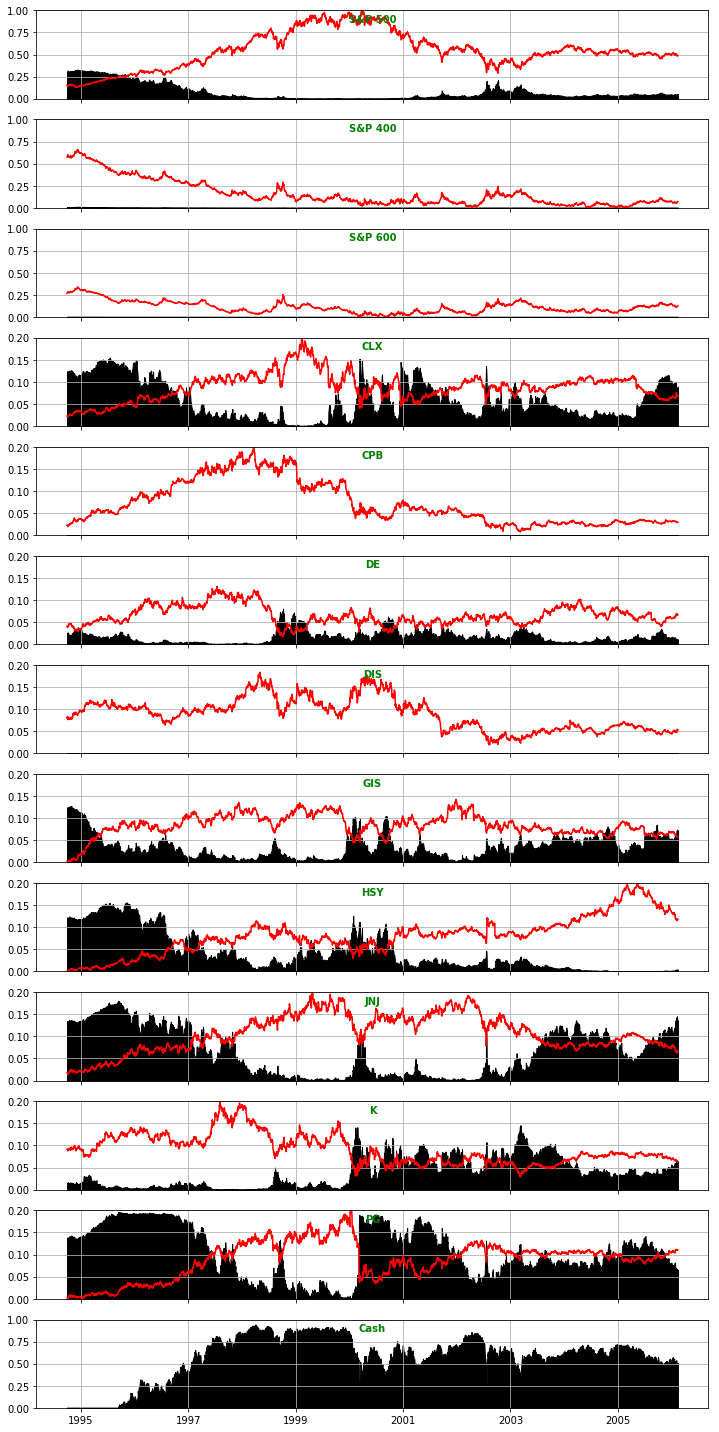

In [46]:
plot_weights_signals(idx=idx_train)

We now show the stock-weights and signals for the test-set. This is "out-of-sample" data that was not used during optimization of the portfolio model. We see that the portfolio model still scales the stock-weights according to their signals, so it seems to do what we expect.

Note that the weights will most likely change every time you run this, because we are using a stochastic heuristic optimizer to find the parameters for the portfolio model.

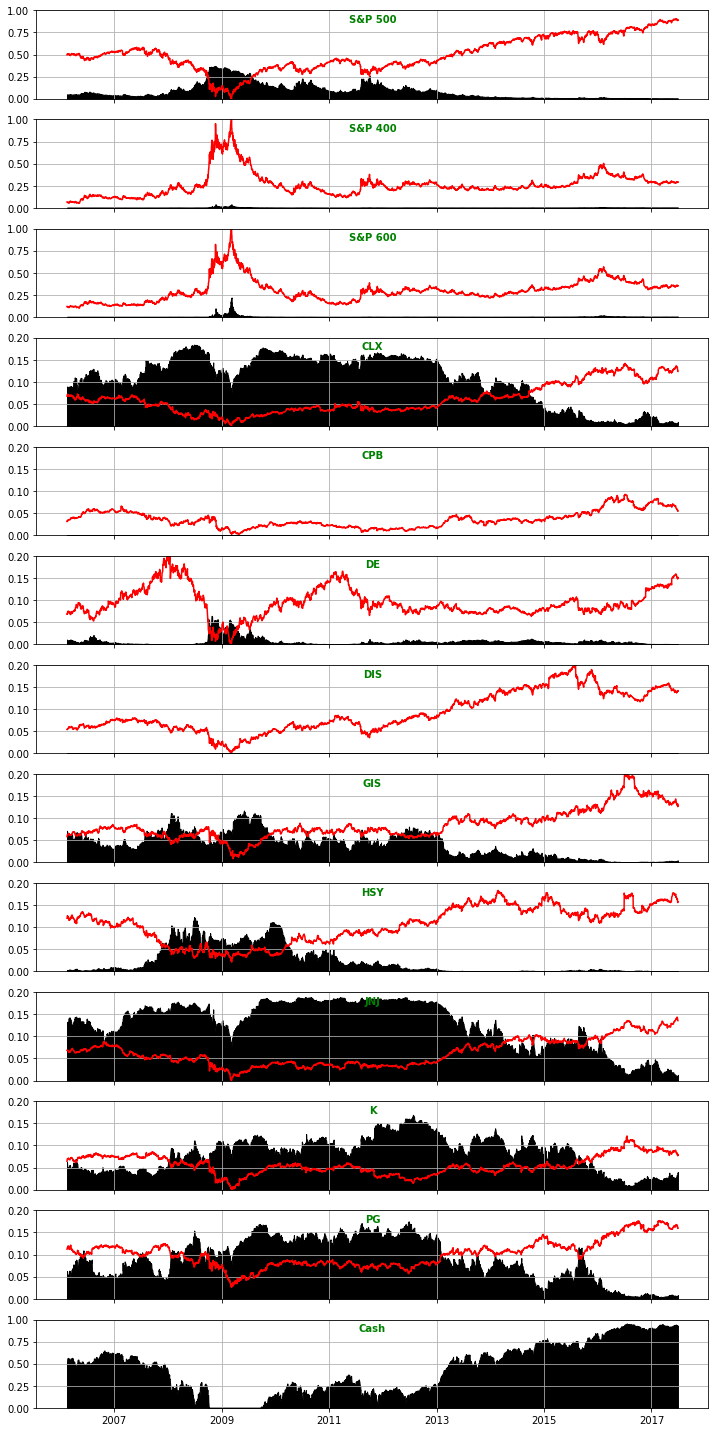

In [47]:
plot_weights_signals(idx=idx_test)

### Stock-Weights: Max Return

We now plot the stock-weights that maximized the mean return on the training-set. We first plot them for the training-set. Note how small the cash-weight is in comparison to the low-risk weights shown above.

In [48]:
portfolio_adapt.use_best_parameters_max_return()

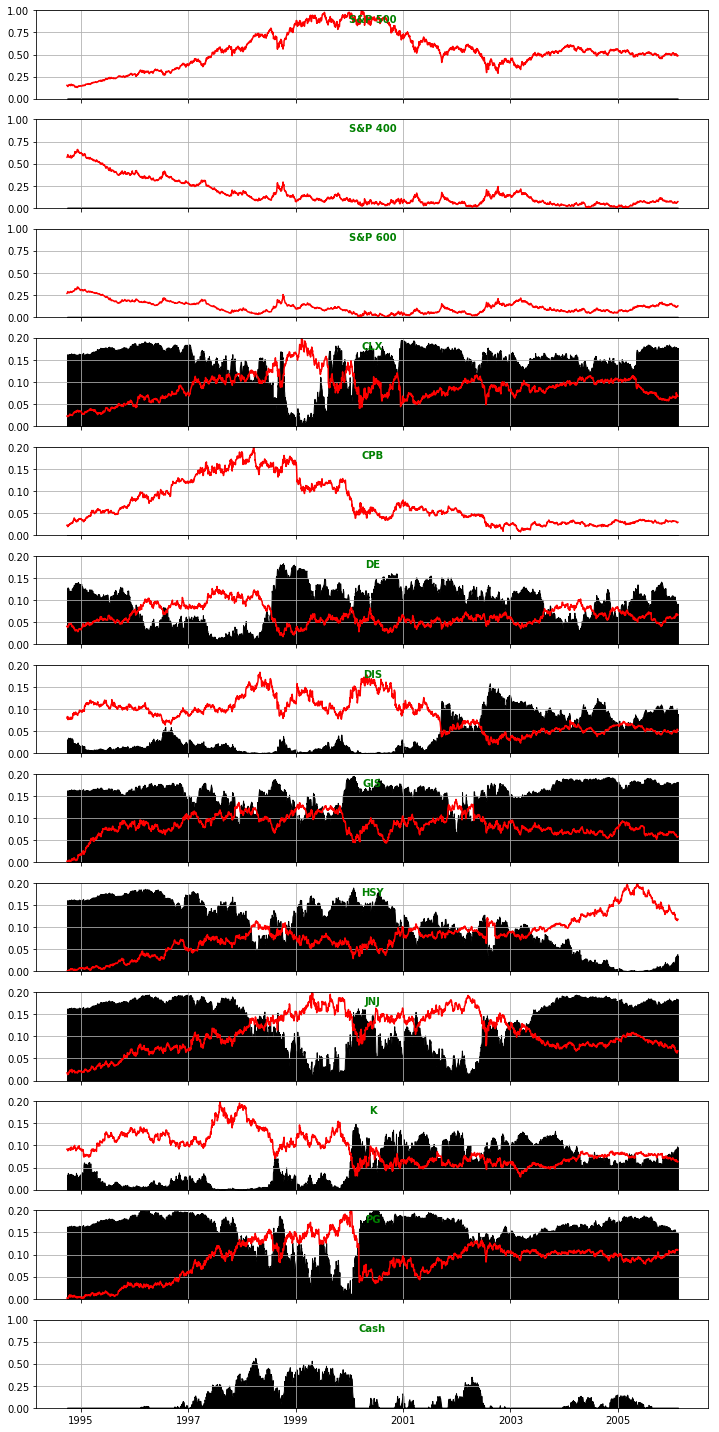

In [49]:
plot_weights_signals(idx=idx_train)

We now plot the stock-weights for the test-set, using the same model parameters that maximized the mean return on the training-set.

This is "out-of-sample" data but we see that the portfolio model still scales the stock-weights according to their signals, so it seems to do what we expect. Note that the cash-weights are still very low for most of the period.

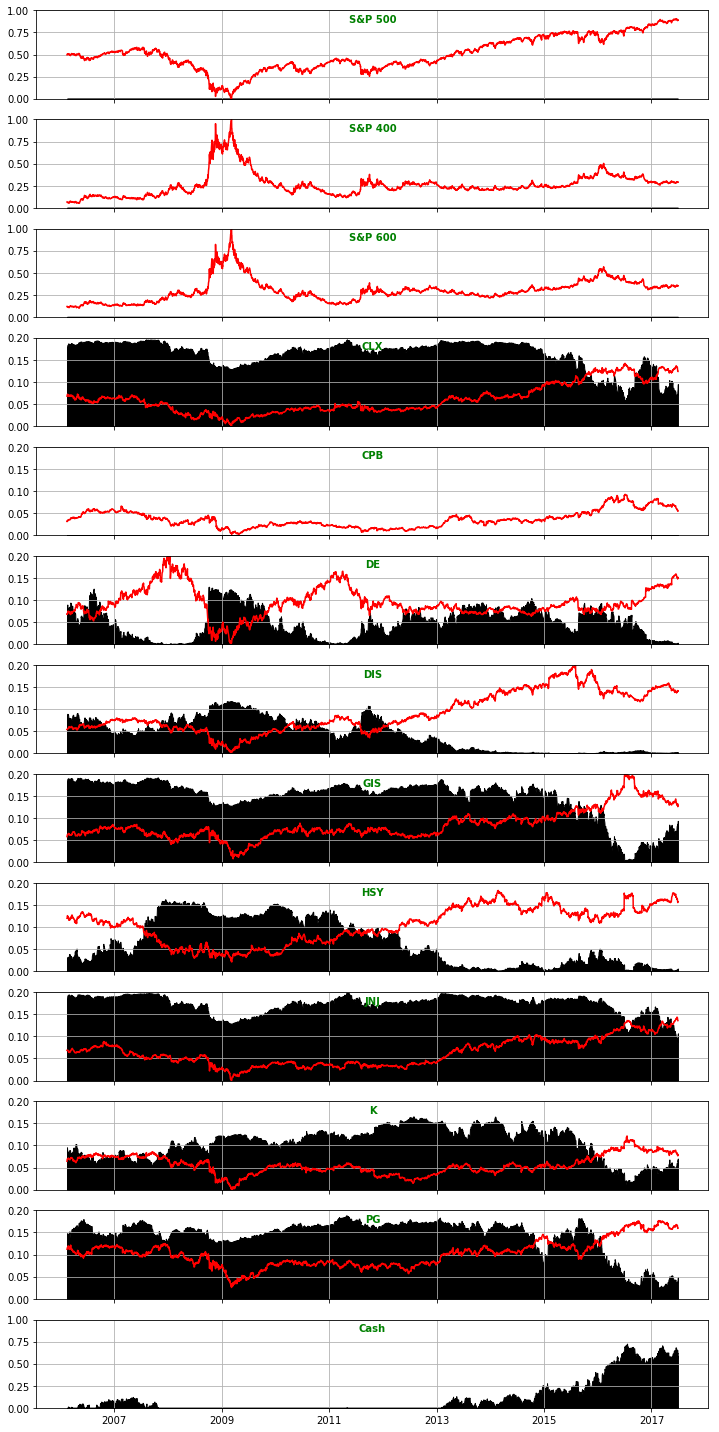

In [50]:
plot_weights_signals(idx=idx_test)

## Compare Returns

In [51]:
def plot_comparison(title, idx, tickers, dfs):
    """
    Plot comparison of Total Return for the given tickers
    and the adaptive portfolio with low-risk and max-return
    stock-weights, as well as a compromise between those two.
    
    :param title: Title of the plot.
    :param idx: List of integer indices into dates, signals, etc.
    :param tickers: List of strings for the tickers.
    :param dfs: List of DataFrames corresponding to the tickers.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Get the data for the period given by the indices.
    dates_idx = dates[idx]
    daily_rets_idx = daily_rets[idx]
    signals_idx = signals_scaled[idx, :]
    
    # Plot the Total Return for the given stocks.
    for ticker, df in zip(tickers, dfs):
        # Get the Total Return for the given period.
        tot_ret = df[TOTAL_RETURN][dates_idx].dropna()
        
        # Normalize to begin at 1.0
        tot_ret /= tot_ret[0]

        # Plot it.
        ax.plot(tot_ret, label=ticker)

    # Plot portfolio value using equal weights.
    value = portfolio_equal.value(daily_rets=daily_rets_idx)
    ax.plot(dates_idx, value, label="Equal Weights")

    # Plot portfolio value with min prob. of loss.
    portfolio_adapt.use_best_parameters_min_prob_loss()
    value = portfolio_adapt.value(daily_rets=daily_rets_idx,
                                  signals=signals_idx)
    ax.plot(dates_idx, value, label="Min Prob Loss")

    # Plot portfolio value with compromise.
    portfolio_adapt.use_best_parameters(max_prob_loss=0.1)
    value = portfolio_adapt.value(daily_rets=daily_rets_idx,
                                  signals=signals_idx)
    ax.plot(dates_idx, value, label="Compromise")
    
    # Plot portfolio value with max return.
    portfolio_adapt.use_best_parameters_max_return()
    value = portfolio_adapt.value(daily_rets=daily_rets_idx,
                                  signals=signals_idx)
    ax.plot(dates_idx, value, label="Max Return")

    # Set the axis-labels.
    ax.set_ylabel("Total Return")
   
    # Add legend to plot.
    ax.legend(loc=0)
    
    # Add grid to plot.
    ax.grid()
    
    # Set the plot's title.
    ax.set_title(title)

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now plot a comparison of the different model parameters to the stock indices. First we show it for the training-set, so this is the period of data used during optimization of the portfolio models. 

We see that the "Min Prob Loss" model indeed had very small losses but also a lower return. Conversely, we see that the "Max Return" model had a much higher return but also greater losses. Also shown is a "Compromise" model which maximized the return given a constraint on the loss-probability, and this performed somewhere between the other two models.

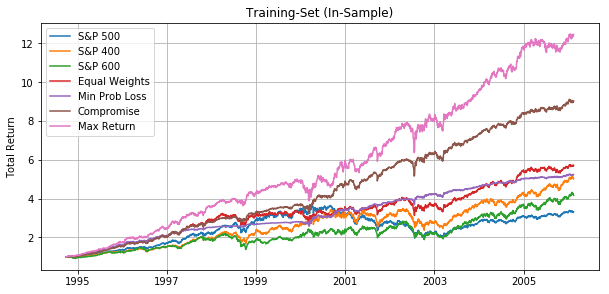

In [52]:
plot_comparison(title="Training-Set (In-Sample)", idx=idx_train,
                tickers=[ticker_SP500, ticker_SP400, ticker_SP600],
                dfs=[df_SP500, df_SP400, df_SP600])

Let us now show the same comparison but for the test-set. This is "out-of-sample" data that was not seen during training of the portfolio models. The results change slightly each time you run this, because the optimization is heuristic and stochastic.

But in general we see the same tendency as for the training-set, namely that the "Min Prob Loss" model had smaller losses but also lower returns, while the "Max Return" model had greater losses and greater returns. The "Compromise" model performs somewhere between these two models.

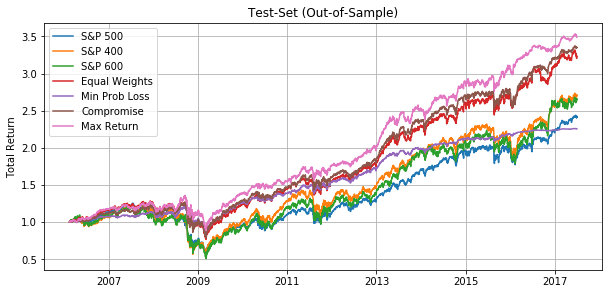

In [53]:
plot_comparison(title="Test-Set (Out-of-Sample)", idx=idx_test,
                tickers=[ticker_SP500, ticker_SP400, ticker_SP600],
                dfs=[df_SP500, df_SP400, df_SP600])

## Discussion

A method was presented for optimizing investment portfolios using predictive signals and multiple conflicting performance goals. This resulted in a so-called Pareto front of portfolio models which optimally compromise between the conflicting goals.

The portfolio models seemed to behave as we expected. They increased the stock-weights when the signals predicted a stock was cheap, and vice versa. The trade-off between conflicting goals also worked well, as we could select portfolio models that either minimized the probability of loss or maximized the return, or any compromise between the two.

However, the method has not been fully tested here as we only used a small number of stocks, and we used signals that are more useful for predicting long-term returns. Because of this, the profit on the test-set was probably insufficient to make up for trading costs and taxes, which we ignored.

If we instead had 100 stocks and limited their weights to e.g. 5% or less of the portfolio, then the diversification would probably help get better portfolio returns on the test-set. It would probably also help to use more predictive signals, especially for short- and mid-term investment periods. But short-term signals are probably fairly weak predictors, which again means that we need more stocks for diversification.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

Here are some ideas you could start researching:

- Try using the standard deviation instead of the probability of loss as the second fitness measure. What happens to the portfolio models and their investment returns?

- Try other fitness measures such as the Kelly Criterion or the Worst Loss. Also try and use different investment periods to calculate these.

- Try rounding the stock-weights e.g. to whole percentages which could be useful for lowering transaction costs.

- Try using monthly instead of daily rebalancing to lower transaction costs.

- The research ideas in the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/03_Portfolio_Optimization_Using_Signals.ipynb) can also be used here.

## License (MIT)

Copyright (c) 2015-18 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.